In [2]:
import pandas as pd
import json
import requests


In [3]:
# Endpoints
page0 = 'https://ucdpapi.pcr.uu.se/api/battledeaths/22.1?pagesize=1000&page=0'
page1 = 'https://ucdpapi.pcr.uu.se/api/battledeaths/22.1?pagesize=1000&page=1'

data_pages = []
for i in [page0, page1]:
  response = requests.get(i)
  data_pages.append(pd.DataFrame(response.json()['Result']))


In [4]:
conflict_data = pd.concat(data_pages)
conflict_data.columns

Index(['conflict_id', 'dyad_id', 'location_inc', 'side_a', 'side_a_id',
       'side_a_2nd', 'side_b', 'side_b_Id', 'side_b_2nd', 'incompatibility',
       'territory_name', 'year', 'bd_best', 'bd_low', 'bd_high',
       'type_of_conflict', 'battle_location', 'gwno_a', 'gwno_a_2nd', 'gwno_b',
       'gwno_b_2nd', 'gwno_loc', 'gwno_battle', 'region', 'version'],
      dtype='object')

In [32]:
bd_deaths = conflict_data.groupby(["conflict_id", 'year', 'location_inc', 'side_a', 'gwno_a', 'gwno_loc'])['bd_best'].sum().reset_index()
bd_deaths

,conflict_id,year,location_inc,side_a,gwno_a,gwno_loc,bd_best
0,11342,2012,India,Government of India,750,750,27
1,11342,2014,India,Government of India,750,750,26
2,11344,2011,Sudan,Government of Sudan,625,625,145
3,11345,2011,South Sudan,Government of South Sudan,626,626,105111
4,11345,2012,South Sudan,Government of South Sudan,626,626,137
...,...,...,...,...,...,...,...
1398,439,2014,Myanmar (Burma),Government of Myanmar (Burma),775,775,67
1399,439,2015,Myanmar (Burma),Government of Myanmar (Burma),775,775,309
1400,439,2017,Myanmar (Burma),Government of Myanmar (Burma),775,775,35
1401,439,2021,Myanmar (Burma),Government of Myanmar (Burma),775,775,71


## PSED Data

In [6]:
df = pd.read_csv('data/PSED 1990-2012 Feb 2019.csv', encoding='latin-1')
df.head()

,Event ID,Name,Event Type,Region Code,Country Code,Year,Start Date,End Date,City,Province,...,Injuries Type - Rebel,Injuries Type - Politician,Incicdent Type - PSC Discharged Weapon,Incident Type - PSC Killed or Injured,Incident Type - Casualty or Damage by PSC,Incident Type - Weapon Discharged Against PSC,Incident Type - Nonlethal Countermeasures,Organizations,PSC Nationality,Description
0,100001,Cambodia 1990-07-14 VIOLENCEANTIGOV,VIOLENCE,PSM-SEA,KHM,1990,7/14/90,7/14/90,Takeo,Takeo,...,0,0,0,1,0,0,0,NaN,VNM,Khmer Rouge guerrillas claimed to have attacke...
1,100002,Cambodia 1993-05-03 VIOLENCEANTIGOV,VIOLENCE,PSM-SEA,KHM,1993,5/3/93,5/3/93,NaN,NaN,...,0,0,0,0,0,0,1,NaN,FRA,Article about the French Foreign Legion; in la...
2,100003,Cambodia 1994-03-19 VIOLENCEPROGOV,VIOLENCE,PSM-SEA,KHM,1994,3/19/94,3/19/94,Pailin,NaN,...,0,0,0,1,0,0,0,NaN,VNM,Khmer Rouge accused Cambodian government of em...
3,100004,Cambodia 1996-06-01 PSCCRIME,CRIME,PSM-SEA,KHM,1996,6/1/96,6/30/96,Phnom Penh,NaN,...,0,0,0,0,0,0,0,NaN,NaN,Crackdown against hundreds of foreign gangster...
4,100005,Cambodia 1997-01-01 PSCWORKING,WORK,PSM-SEA,KHM,1997,1/1/97,12/31/97,NaN,NaN,...,0,0,0,0,0,0,0,Protek Cambodia Security Company Limited,FRA,"Cambodian court charged, tried, and convicted ..."


In [7]:
from ccode_replace_python import replace_ccode_country as rcc
import pycountry


In [18]:
def make_country_code(x):
    return pycountry.countries.lookup(x['Country Code']).name
df['country_name'] = df.apply(make_country_code, axis=1)
df = rcc.ccode_make(df, 'country_name')


In [28]:
df['count'] = 1
psed_year = df.groupby(['ccode', 'Year'])['count'].sum().reset_index()
psed_year['ccode'] = psed_year['ccode'].astype(int)
psed_year['Year'] = psed_year['Year'].astype(int)
psed_year.head()

,ccode,Year,count
0,70,1993,1
1,70,1994,2
2,70,1995,1
3,70,1996,2
4,70,1997,2


In [33]:

bd_deaths.gwno_a = bd_deaths.gwno_a.str.replace('900, 200, 2', '900')
bd_deaths.gwno_a = bd_deaths.gwno_a.astype(int)

bd_deaths.year = bd_deaths.year.astype(int)


In [40]:
merged = bd_deaths.merge(psed_year, left_on=['gwno_a', 'year'], right_on=['ccode', 'Year'], how='left')
merged

,conflict_id,year,location_inc,side_a,gwno_a,gwno_loc,bd_best,ccode,Year,count
0,11342,2012,India,Government of India,750,750,27,NaN,NaN,NaN
1,11342,2014,India,Government of India,750,750,26,NaN,NaN,NaN
2,11344,2011,Sudan,Government of Sudan,625,625,145,625.0,2011.0,1.0
3,11345,2011,South Sudan,Government of South Sudan,626,626,105111,626.0,2011.0,1.0
4,11345,2012,South Sudan,Government of South Sudan,626,626,137,626.0,2012.0,4.0
...,...,...,...,...,...,...,...,...,...,...
1398,439,2014,Myanmar (Burma),Government of Myanmar (Burma),775,775,67,NaN,NaN,NaN
1399,439,2015,Myanmar (Burma),Government of Myanmar (Burma),775,775,309,NaN,NaN,NaN
1400,439,2017,Myanmar (Burma),Government of Myanmar (Burma),775,775,35,NaN,NaN,NaN
1401,439,2021,Myanmar (Burma),Government of Myanmar (Burma),775,775,71,NaN,NaN,NaN


<AxesSubplot:xlabel='bd_best', ylabel='count'>

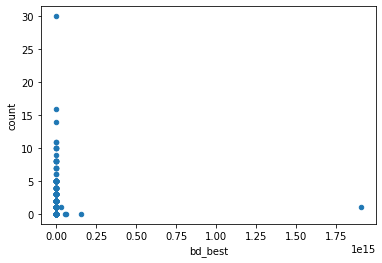

In [47]:
merged.bd_best = merged.bd_best.astype(int)
merged.fillna(0)[['bd_best', 'count']].plot(kind='scatter', x='bd_best', y='count')